### Import Libraries

In [1]:
import warnings
def warn(*arg, **kwargs):
    pass
warnings.warn = warn

In [2]:
# !pip install edward

In [3]:
seed = 2018
import math
import numpy as np
import edward as ed
ed.set_seed(seed)
import pandas as pd
import tensorflow as tf
np.random.seed(seed= seed)

from time import time
from edward.models import Categorical, Normal
from keras.utils import to_categorical
from plot_feature import plot_feature

import seaborn as sns
from scipy import stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import ticker
from sklearn.utils import resample
import scipy.special
from matplotlib.mlab import griddata
import matplotlib.tri as tri

Instructions for updating:
Use the retry module or similar alternatives.


Using TensorFlow backend.


In [4]:
tf.set_random_seed(seed)

In [5]:
import dill
import pickle
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from bokeh.layouts import gridplot
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [6]:
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.decomposition import PCA

### Plot related setups

In [7]:
# inspired by http://nipunbatra.github.io/2014/08/latexify/
%matplotlib inline

plt.style.use(['default'])
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 12, # was 10
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': True,
    'font.family': 'serif',
}
plt.rcParams.update(params)

### Import Data

In [8]:
## look data with pandas
train_file = "data/rupturemodel_train.txt"
val_file = "data/rupturemodel_xvalidate.txt"
test_file = "data/rupturemodel_test.txt"

df_train= pd.read_csv(train_file, sep=" ", header = None, dtype = np.float32)
df_val= pd.read_csv(val_file, sep=" ", header = None, dtype = np.float32)
df_test= pd.read_csv(test_file, sep=" ", header = None, dtype = np.float32)

features_name =  ['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc', 'label']
df_train.columns = features_name
df_val.columns = features_name
df_test.columns = features_name

df_train_all = df_train.append(df_val)

### Data processing
We use StandardScaler preprocessing method of scikit. It standardizes features 
by removing the mean and scaling to unit variance

In [9]:
df = shuffle(df_train_all, random_state = seed)
df_test = shuffle(df_test, random_state = seed)

In [10]:
df.shape

(1600, 9)

### Class Balance

In [11]:
df.label.value_counts()

0.0    1041
1.0     559
Name: label, dtype: int64

In [12]:
df_major = df[df.label == 0]
df_minor = df[df.label == 1]

In [13]:
df_minor.shape[0]

559

In [36]:
df_minor_upsmapled = resample(df_minor, replace = True, n_samples = df_major.shape[0], random_state = 100)

In [37]:
df_minor_upsmapled = pd.concat([df_minor_upsmapled, df_major])

In [38]:
df_minor_upsmapled.label.value_counts()

0.0    1041
1.0    1041
Name: label, dtype: int64

### Analysis

In [39]:
features =['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc']

/Users/sabber/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



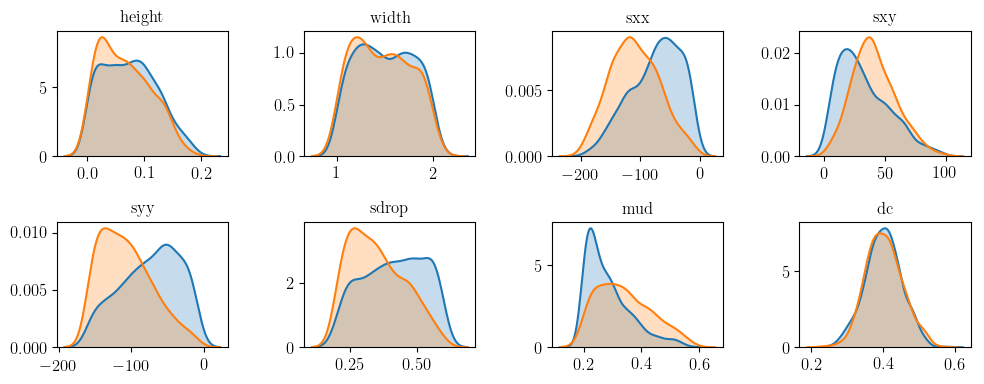

In [40]:
plt.figure(figsize=(10, 4))

for i, feature in enumerate(features):
    plt.subplot(2, 4, i + 1)
    sns.kdeplot(df[feature][df.label == 0], shade= True, legend=False)
    sns.kdeplot(df[feature][df.label == 1], shade= True, legend=False)
    plt.title(feature)
    
plt.tight_layout()
plt.show()

### Fetaure Scaling

In [41]:
mms = StandardScaler()
train_scale = mms.fit(df_minor_upsmapled.drop('label', axis=1))

xtrain = train_scale.transform(df_minor_upsmapled.drop('label', axis=1))
ytrain =  np.array(df_minor_upsmapled['label'].values)
ytrain = ytrain.reshape(ytrain.shape[0], 1)

xtest = train_scale.transform(df_test.drop('label', axis=1))
ytest = np.array(df_test['label'].values)
ytest = ytest.reshape(ytest.shape[0], 1)

In [42]:
np.shape(xtrain)

(2082, 8)

### Feature analysis

In [47]:
# plot_feature(df, 'height', True, False)

In [48]:
# plot_feature(df, 'sxy', True, False)

In [49]:
# plot_feature(df, 'sdrop', True, False)

## Model setup

### 1. Hyperparameters 

In [50]:
## Hyperparameters
N = np.shape(xtrain)[0]
in_size = np.shape(xtrain)[1]
out_size = 1
l1 = 12 # Number of neurons in the first layer
BATCH_SIZE = 32

### 2. Define neural network

In [51]:
def neural_network(X, W_0, W_1, b_0, b_1):
    hidden1 = tf.nn.relu(tf.matmul(X, W_0) + b_0)
    output = tf.nn.sigmoid(tf.matmul(hidden1, W_1) + b_1)
    return output

In [52]:

with tf.name_scope('model_prior'):
    
    W_0 = Normal(loc = tf.zeros([in_size, l1], name="weights/loc_w_0"), 
                 scale = tf.ones([in_size, l1], name="weights/scale_w_0"),
                 name  = 'weight_w_0')
    W_1 = Normal(loc=tf.zeros([l1, out_size], name="weights/loc_w_1"), 
                 scale=tf.ones([l1, out_size], name="weights/scale_w_1"),
                 name  = 'weight_w_1')
    b_0 = Normal(loc=tf.zeros(l1, name="weights/loc_b_0"), 
                 scale=tf.ones(l1, name="weights/scale_b_0"),
                 name  = 'weight_b_0')
    b_1 = Normal(loc=tf.zeros(out_size, name="weights/loc_b_1"),
                 scale=tf.ones(out_size, name="weights/scale_b_1"),
                 name  = 'weight_b_1')
    
    X = tf.placeholder(tf.float32, shape = (None, in_size)) 
    y = Normal(loc = neural_network(X, W_0, W_1, b_0, b_1), scale = 1.0)

### Model posterior weights

In [53]:
with tf.name_scope('posterior'):
    qW_0 = Normal(loc = tf.Variable(tf.random_normal([in_size, l1]), name = "weights/loc_qw_0" ), 
                  scale = tf.Variable(tf.random_normal([in_size, l1]), name = "weights/scale_qw_0"),
                  name = "weight_qw_0")
    
    qW_1 = Normal(loc = tf.Variable(tf.random_normal([l1, out_size]), name = "weights/loc_qw_1" ), 
                  scale = tf.Variable(tf.random_normal([l1, out_size]), name = "weights/loc_qw_1" ),
                  name = "weight_qw_1")
    
    qb_0 = Normal(loc = tf.Variable(tf.random_normal([l1]), name = "weights/loc_qb_0" ), 
                scale = tf.Variable(tf.random_normal([l1]), name = "weights/loc_qb_0" ),
                name = "weight_qb_0")
    qb_1 = Normal(loc = tf.Variable(tf.random_normal([out_size]), name = "weights/loc_qb_1" ), 
                scale = tf.Variable(tf.random_normal([out_size]), name = "weights/loc_qb_1" ),
                name = "weight_qb_1")

## Inference

In [54]:
with tf.name_scope("inference"):
    
    inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                         W_1: qW_1, b_1: qb_1}, 
                        data={X: xtrain, 
                              y: ytrain})

    global_step = tf.Variable(0, trainable = True, name = "global_step")
    initial_learning_rate = tf.Variable(0.001, trainable = True, name = "initial_learning_rate")

    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               10000, 0.3, staircase = True, name = 'learning_rate')

    optimizer = tf.train.AdamOptimizer(learning_rate)

    inference.run(n_iter = 5000, optimizer = optimizer, global_step = global_step, logdir = r'./log')

5000/5000 [100%] ██████████████████████████████ Elapsed: 19s | Loss: 2214.455


## Sampling 

In [55]:
%%time

### Sample weights
n_samples = 1000
qW_0_samples = qW_0.sample(sample_shape = n_samples, seed = 2018)
qW_1_samples = qW_1.sample(sample_shape = n_samples, seed = 2018)
qb_0_samples = qb_0.sample(sample_shape = n_samples, seed = 2018)
qb_1_samples = qb_1.sample(sample_shape = n_samples, seed = 2018)

### Save sampled weights
weights = dict()
weights['qW_0_samples'] = qW_0_samples.eval()
weights['qW_1_samples'] = qW_1_samples.eval()
weights['qb_0_samples'] = qb_0_samples.eval()
weights['qb_1_samples'] = qb_1_samples.eval()
with open('model_weights.pkl', 'wb') as file:
    pickle.dump(weights, file, protocol=pickle.HIGHEST_PROTOCOL)

CPU times: user 1.81 s, sys: 32.5 ms, total: 1.84 s
Wall time: 1.88 s


### Stacking weights

In [56]:
%%time
samplenodes = tf.stack([neural_network(X, qW_0_samples[i], qW_1_samples[i],
                                       qb_0_samples[i], qb_1_samples[i]) 
                        for i in range(n_samples)], axis=0)

CPU times: user 18.7 s, sys: 438 ms, total: 19.1 s
Wall time: 21.4 s


### Predict with sampled weights

In [57]:
%%time
def get_prediction(x):
    sample_predictions = samplenodes.eval(feed_dict={X: x})
    predictions_samp = sample_predictions[:, :, 0]
    return predictions_samp
predictions_samp = get_prediction(xtest)

CPU times: user 8.46 s, sys: 181 ms, total: 8.64 s
Wall time: 8.78 s


### Prior and posterior weight vizualization

In [58]:
### prior weights
prior_weights = W_0.eval(), W_1.eval(), b_0.eval(), b_1.eval()

### Posterior mean weights
post_weights_mean = qW_0_samples.eval().mean(axis = 0), qW_1_samples.eval().mean(axis = 0),\
               qb_0_samples.eval().mean(axis = 0), qb_1_samples.eval().mean(axis = 0)

In [59]:
### Posterior standard deviation of weights
post_weights_std = qW_0_samples.eval().std(axis = 0), qW_1_samples.eval().std(axis = 0),\
               qb_0_samples.eval().std(axis = 0), qb_1_samples.eval().std(axis = 0)

In [60]:
wgt = ['w$^0$', 'w$^1$', 'b$^0$', 'b$^1$']
lbl = ['a', 'b', 'c', 'd']
def plot_weight_distribution(prior = True):

    plt.figure(figsize=(8, 6))
    
    for i in range(len(prior_weights)):
        plt.subplot(2, 2, i+1)
        if i == 3:
            plt.plot(prior_weights[i].reshape(-1), "ro", label = 'Prior')
            plt.plot(post_weights_mean[i].reshape(-1), "bo", label = 'Prior')
        else:
            sns.kdeplot(prior_weights[i].reshape(-1), shade = True, color = "r", label = 'Prior')
            sns.kdeplot(post_weights_mean[i].reshape(-1), shade = True, color = "b", label = 'Posterior')

        plt.title('(' + lbl[i] + ') ' + wgt[i])
        plt.ylabel('Density')
        plt.xlabel('Weight')
        
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()
    plt.savefig('./figures/posterior_weight.png')

/Users/sabber/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



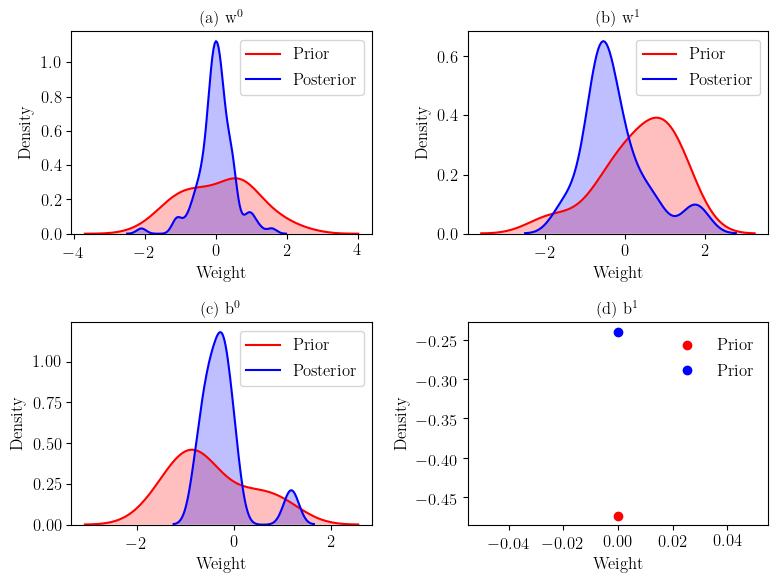

<Figure size 640x480 with 0 Axes>

In [61]:
plot_weight_distribution()

### Model weights mean and standard deviation

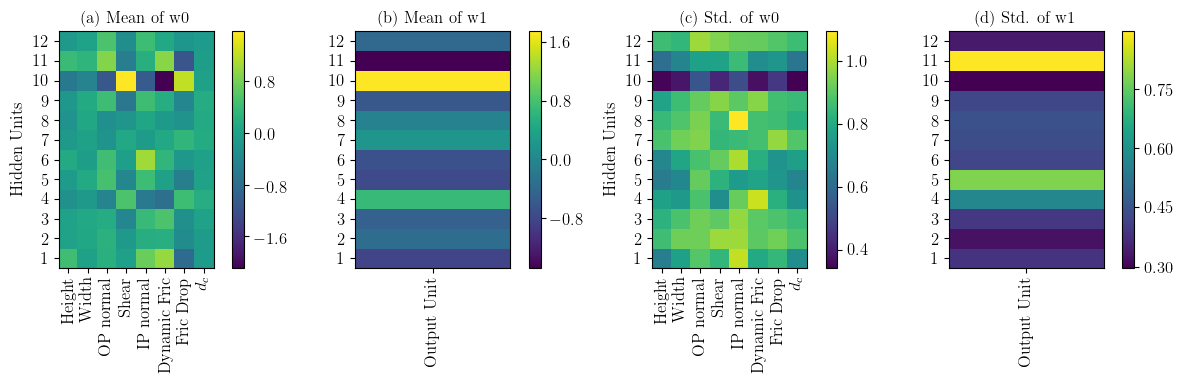

In [62]:
# %matplotlib notebook

plt.figure(figsize=(12, 4))

wgt = ['Mean of w0', 'Mean of w1', 'Std. of w0', 'Std. of w1']
lbl = ['a', 'b', 'c', 'd']

k = 0
for i in range(2):
    if i == 0:
        weights = post_weights_mean
    else:
        weights = post_weights_std
        
    plt.subplot(1,4, k + i + 1)
    aa = np.transpose(weights[0])
    plt.pcolormesh(aa, cmap = 'viridis', vmin = np.min(weights[0]), vmax = np.amax(weights[0]))
    labels = ['Height', 'Width', 'OP normal', 'Shear', 'IP normal', 'Dynamic Fric', 'Fric Drop', '$d_c$']

    plt.xticks([0.5+float(x) for x in range(0,8)], labels, rotation='vertical')
    plt.yticks([0.5+float(x) for x in range(0,12)], list(range(1,13)))
    plt.ylabel('Hidden Units')
    plt.title('('+ lbl[k + i] + ') ' + wgt[k + i])

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)

    cb = plt.colorbar(orientation="vertical",fraction=0.07, pad=0.1)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()

    # Layer two plot
    plt.subplot(1, 4, k+i+2)
    bb = np.reshape(weights[1], (12, 1))
    plt.pcolormesh(bb, cmap = 'viridis', vmin = np.min(weights[1]), vmax = np.amax(weights[1]))
    plt.xticks([0.5],['Output Unit'],rotation='vertical')
    plt.yticks([0.5+float(x) for x in range(0,12)], list(range(1,13)))
    plt.title('('+ lbl[k+i+1] + ') ' + wgt[k+i+1])

    cb = plt.colorbar(orientation="vertical",fraction=0.07, pad=0.1)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()
    k = 1

plt.tight_layout()
plt.savefig('./figures/network_uncertainity.eps')
plt.show()

### Evaluation

In [63]:
###
results = pd.DataFrame()
results['target'] = list(ytest)
results.target = results.target.apply(lambda x: int(x[0]))

In [64]:
results['predictions'] = predictions_samp.mean(axis = 0)
results['predStd'] = predictions_samp.std(axis = 0)
results['predVar'] = predictions_samp.var(axis = 0)

In [65]:
zzz = stats.norm.interval(0.95, loc = results['predictions'], scale = results['predStd'])
results['confidenceLow'] = np.transpose(zzz)[:, 0]
results['confidenceHigh'] = np.transpose(zzz)[:, 1]
results['confidenceRange'] = np.absolute(results['confidenceHigh'] - results['confidenceLow'])

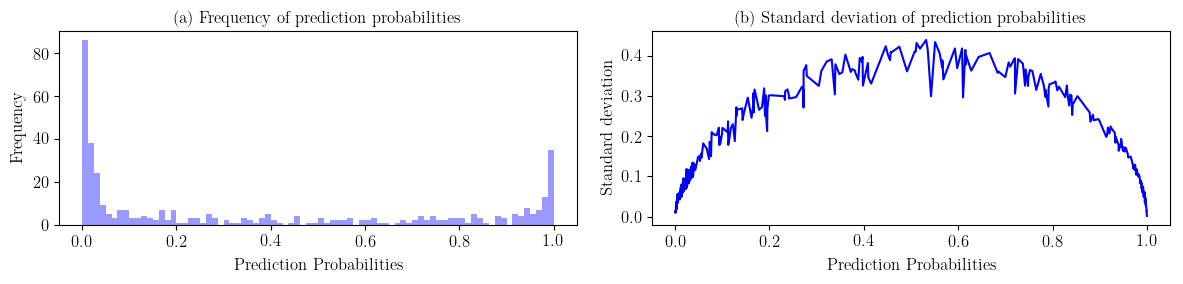

In [66]:
plt.figure(figsize=(12, 3))
plt.subplot(121)
sns.distplot(results.predictions, kde = False, bins = 80, color = 'blue')
plt.xlabel('Prediction Probabilities')
plt.title('(a) Frequency of prediction probabilities')
plt.ylabel('Frequency')

plt.subplot(122)
sns.lineplot(x = "predictions", y = "predStd", data = results, color = 'blue')
plt.xlabel('Prediction Probabilities')
plt.title('(b) Standard deviation of prediction probabilities')
plt.ylabel('Standard deviation')
plt.tight_layout()
plt.savefig('./figures/uncertainity_statistics.eps')
# plt.show()

In [67]:
def get_optimal_threshold():  
    thresholds = list(np.linspace(0, 1, 1000))
    f1_scores = []
    for threshold in thresholds:
        ypred = results.predictions.apply(lambda x: 1 if x >= threshold else 0)
        f1_scores.append(f1_score(ytest, ypred, average = 'weighted'))

    return f1_scores, thresholds

In [68]:
f1_scores, th = get_optimal_threshold()

In [69]:
print(np.round(np.max(f1_scores)*100, 2), th[np.argmax(f1_scores)])

83.74 0.5085085085085085


In [70]:
threshold = th[np.argmax(f1_scores)]
results['binPred'] = results.predictions.apply(lambda x: 1 if x >= threshold else 0)

def prediction(ytest, ypred):
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('F1-score of the model: {}\n'.format(f1_score(ytest, ypred, average='weighted')))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytest, ypred)))

prediction(ytest, results['binPred'])

Accuracy of the model: 0.835

F1-score of the model: 0.8373529411764707

Classification report: 
             precision    recall  f1-score   support

        0.0       0.90      0.85      0.88       272
        1.0       0.72      0.80      0.76       128

avg / total       0.84      0.83      0.84       400


Confusion matrix: 
[[231  41]
 [ 25 103]]



### Uncertainity surface vizualisation

In [71]:
pca = PCA(n_components = 2, random_state = 2018).fit_transform(xtest)
results['pca_x1'] = pca[:, 0]
results['pca_x2'] = pca[:, 1]

In [72]:
xi = np.linspace(-6, 6, 1000)
yi = np.linspace(-5, 5, 1000)
x, y = results.pca_x1, results.pca_x2

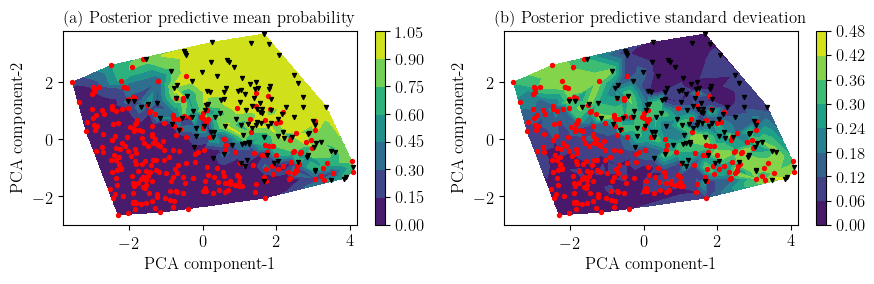

In [73]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(9, 3))
cmap = 'viridis'
axes = [ax1, ax2]
titles = ['(a) Posterior predictive mean probability', '(b) Posterior predictive standard devieation']
datas = [results.predictions, results.predStd]

for ax, data, title in zip(axes, datas, titles):
    zi = griddata(x, y, data, xi, yi, interp = 'linear')
    contour = ax.contourf(xi, yi, zi, cmap = cmap)
    ax.scatter(results.pca_x1[results.target == 0], results.pca_x2[results.target == 0], color = 'r', s = 8, marker = 'o')
    ax.scatter(results.pca_x1[results.target == 1], results.pca_x2[results.target == 1], color = 'k', s = 8, marker = 'v')
    ax.set_title(title)
    cbar = plt.colorbar(contour, ax = ax)
    _ = ax.set(xlim = (-3.8, 4.2), ylim = (-3, 3.8), xlabel = 'PCA component-1', ylabel = 'PCA component-2')
fig.tight_layout()
fig.savefig('./figures/posterior_proba_uncertainity.eps')

### Permutation Feature ucertainity

In [74]:
all_list = []
featinfo = pd.DataFrame()
for i in range(len(features)):
    x = xtest.copy()
    np.random.shuffle(x[:, i])
    predictions_samp = get_prediction(x)
    mean = predictions_samp.mean(axis = 0)
    std  = predictions_samp.std(axis = 0)
    all_list.append(std)
    pred = [1 if val >= threshold else 0 for val in mean]
    f1 = f1_score(ytest, pred, average='weighted')
    featinfo = featinfo.append({'Feature': features[i], 'mean': mean.mean(),
                    'std': std.std(), 'f1': f1}, ignore_index=True)

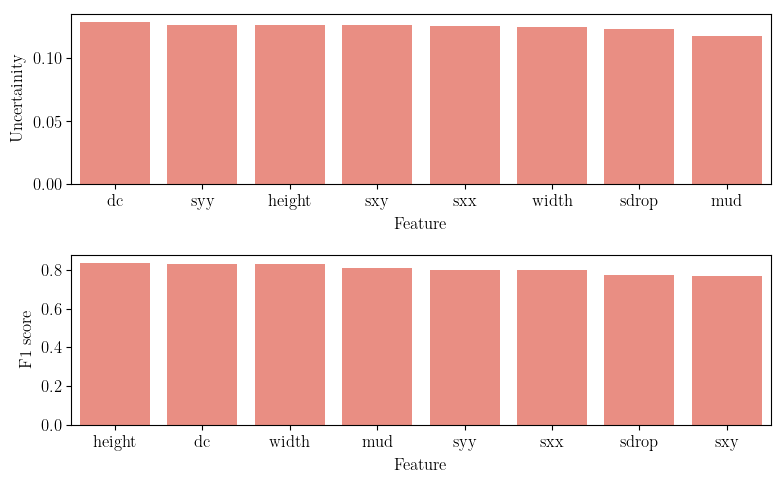

In [81]:
plt.figure(figsize=(8, 5))
featinfo.sort_values(by = 'std', inplace=True, ascending=False)
plt.subplot(211)
ax = sns.barplot(x="Feature", y="std", data=featinfo, color="salmon")
plt.xlabel('Feature')
plt.ylabel('Uncertainity')

plt.subplot(212)
featinfo.sort_values(by = 'f1', inplace=True, ascending=False)
ax = sns.barplot(x="Feature", y="f1", data=featinfo, color="salmon")
plt.xlabel('Feature')
plt.ylabel('F1 score')
plt.tight_layout()

In [76]:
all_list.append(results.predictions.values)
aa = np.array(all_list)
xx = pd.DataFrame(aa, index=['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc', 'score'])
xx.sort_values(axis =1, by= 'score', inplace=True)

In [116]:
def double_heatmap(data1, data2, cbar_label1, cbar_label2,
                   title='', subplot_top=0.86, cmap1='magma', cmap2='viridis', 
                   center1=0.5, center2=0, grid_height_ratios=[0.35,3],
                   figsize=(10,9)):

    fig, (ax,ax2) = plt.subplots(nrows=2, figsize=figsize, 
                                 gridspec_kw={'height_ratios':grid_height_ratios})

    fig.suptitle(title)
    fig.subplots_adjust(hspace=0.02, top=subplot_top)

    # heatmap for actual and predicted percentiles
    sns.heatmap(data1, cmap=cmap1, ax=ax, xticklabels=False, center=center1,
                cbar_kws={'location':'top', 
                          'use_gridspec':False, 
                          'pad':0.1,
                          'label': cbar_label1})
    ax.set_xlabel('')

    # heatmap of the feature contributions
    sns.heatmap(data2, ax=ax2, xticklabels=False, center=center2, cmap=cmap2,
                cbar_kws={'location':'bottom', 
                          'use_gridspec':False, 
                          'pad':0.07, 
                          'shrink':0.41,
                          'label': cbar_label2})
    ax2.set_ylabel('');
    return fig

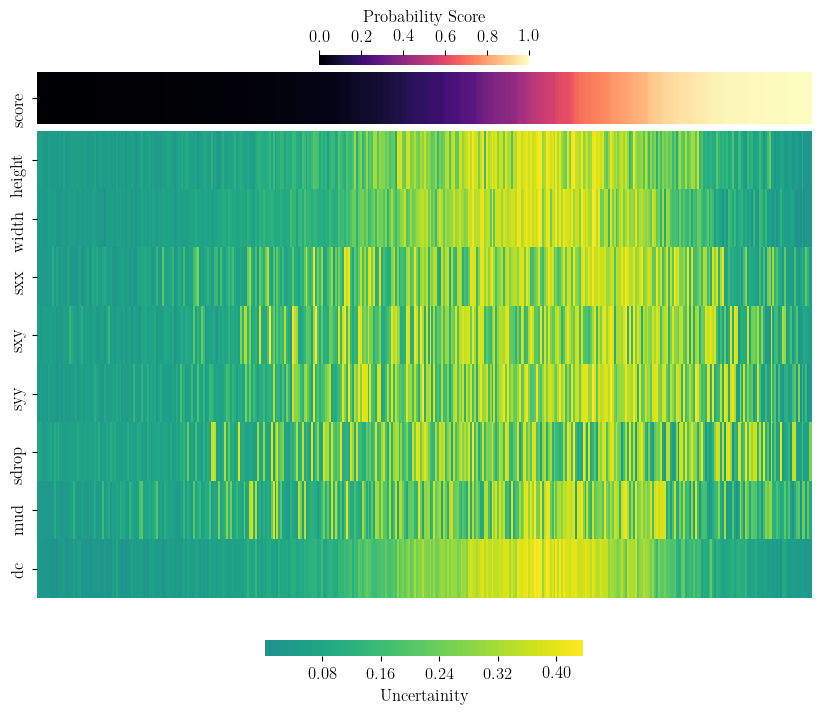

In [117]:
df_score = pd.DataFrame(xx.loc['score', :])
df_std = xx.loc[features, :]
title = 'Feature contributions to predicted AV %ile \nfor each player in the testing data'
fig = double_heatmap(df_score.T, df_std, 'Probability Score', 'Uncertainity')
fig.savefig('./figures/uncertainity_score.eps')